<a href="https://colab.research.google.com/github/Rohanrathod7/Kaggle_Notebooks/blob/main/Predicting_Heart_disease/Experiment_Notebook/Raw_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna-integration[lightgbm]
import os
import time
import warnings

import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

!pip install optuna
import optuna
from tqdm.notebook import tqdm
import lightgbm as lgb
import xgboost as xgb
from optuna.integration import LightGBMPruningCallback, XGBoostPruningCallback

import sklearn
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, StratifiedShuffleSplit, ShuffleSplit
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, LabelEncoder, RobustScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# ====================================================
# Setup & Imports
# ====================================================

import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings for cleaner output and consistent plotting
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12, 8)

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("Setup complete: Warnings suppressed, plotting styles set, and reproducibility ensured.")

# --- Data Loading and Initial Inspection ---

# Flags for data processing based on user's snippet
ADD_EXTERN_DATA = False # Set to True to add external data to training set
STRAT = False           # Not directly used in current CV strategy, but kept for consistency
EXTENDED_STRAT = False  # Set to True to use 'multicat' for stratification in KFold

# 2. Define the file paths, assuming they are in a subfolder like 'Colab Notebooks' within My Drive
train_path = '/content/drive/MyDrive/Kaggle/predicting_heart_dieses/train.csv'
test_path = '/content/drive/MyDrive/Kaggle/predicting_heart_dieses/test.csv'
sample_submission_path = '/content/drive/MyDrive/Kaggle/predicting_heart_dieses/sample_submission.csv'
orig_path = '/content/drive/MyDrive/Kaggle/predicting_heart_dieses/Heart_Disease_Prediction.csv'

df_train_raw = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_orig = pd.read_csv(orig_path)
df_sample_submission = pd.read_csv(sample_submission_path)
print("Datasets loaded successfully.")

# Apply external data if flag is set
if ADD_EXTERN_DATA:
    print("Concatenating external data with training data...")

    # Columns common to both df_train_raw and df_orig_raw, excluding 'id'
    common_cols_for_concat = [col for col in df_train_raw.columns if col != 'id']

    # Ensure both dataframes have the common columns
    df_train_temp = df_train_raw[common_cols_for_concat].copy()
    df_orig_temp = df_orig_raw[common_cols_for_concat].copy()

    df_train = pd.concat([df_train_temp, df_orig_temp], ignore_index=True)
    # Recreate the 'id' column as suggested in the user's snippet
    df_train = df_train.reset_index().rename(columns={'index': 'id'})
    print(f"External data added. New df_train shape: {df_train.shape}")
else:
    df_train = df_train_raw.copy()

# --- 2. Print the shape of each dataset ---
print("\n--- Dataset Shapes ---")
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_test: {df_test.shape}")
print(f"Shape of df_orig_raw (original external data): {df_orig_raw.shape}")
print(f"Shape of df_sample_submission: {df_sample_submission.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete: Warnings suppressed, plotting styles set, and reproducibility ensured.
Datasets loaded successfully.

--- Dataset Shapes ---
Shape of df_train: (630000, 15)
Shape of df_test: (270000, 14)
Shape of df_orig_raw (original external data): (270, 14)
Shape of df_sample_submission: (270000, 2)


In [ ]:
print("Converting 'Heart Disease' column to numerical format...")

# Define the mapping
heart_disease_mapping = {'Absence': 0, 'Presence': 1}

# Convert 'Heart Disease' in df_train
df_train['Heart Disease'] = df_train['Heart Disease'].map(heart_disease_mapping)

# Convert 'Heart Disease' in df_orig_raw if it exists
# (df_orig_raw holds the original external data, df_orig variable is not explicitly created)
if 'Heart Disease' in df_orig_raw.columns:
    df_orig_raw['Heart Disease'] = df_orig_raw['Heart Disease'].map(heart_disease_mapping)

print("Conversion complete.")

print("\n--- Verification for df_train ---")
print(f"Data type of 'Heart Disease' in df_train: {df_train['Heart Disease'].dtype}")
print(f"Unique values in 'Heart Disease' in df_train: {df_train['Heart Disease'].unique()}")

if 'Heart Disease' in df_orig_raw.columns:
    print("\n--- Verification for df_orig_raw ---")
    print(f"Data type of 'Heart Disease' in df_orig_raw: {df_orig_raw['Heart Disease'].dtype}")
    print(f"Unique values in 'Heart Disease' in df_orig_raw: {df_orig_raw['Heart Disease'].unique()}")

Converting 'Heart Disease' column to numerical format...
Conversion complete.

--- Verification for df_train ---
Data type of 'Heart Disease' in df_train: float64
Unique values in 'Heart Disease' in df_train: [nan]

--- Verification for df_orig_raw ---
Data type of 'Heart Disease' in df_orig_raw: float64
Unique values in 'Heart Disease' in df_orig_raw: [nan]


In [ ]:
print("Defining features (X) and target (y) for training...")

X = df_train.drop(columns=['id', 'Heart Disease', 'multicat'])
y = df_train['Heart Disease']

print("Features and target defined successfully.")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Defining features (X) and target (y) for training...
Features and target defined successfully.
Shape of X: (630000, 13)
Shape of y: (630000,)


In [ ]:
print("Calculating class weights for imbalance handling...")

class_counts = y.value_counts()

negative_samples = class_counts[0]
positive_samples = class_counts[1]

# Calculate scale_pos_weight
scale_pos_weight = negative_samples / positive_samples

print(f"Class counts: {class_counts}")
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

print("Class weights calculation complete.")

Calculating class weights for imbalance handling...
Class counts: Heart Disease
0    347546
1    282454
Name: count, dtype: int64
Calculated scale_pos_weight: 1.23
Class weights calculation complete.


In [ ]:
import pandas as pd
import numpy as np

def frq_enc(X, features):
    """
    Performs frequency encoding on specified features.

    Args:
        X (pd.DataFrame): The input DataFrame.
        features (list): A list of column names to frequency encode.

    Returns:
        pd.DataFrame: A new DataFrame with frequency encoded features.
    """
    freq_encodings = {}
    for c in features:
        # Calculate frequencies for each unique value in the feature
        freqs = X[c].value_counts(normalize=True).to_dict()
        freq_encodings[c] = freqs

    X_freq = pd.DataFrame()
    for c in features:
        # Map the original values to their calculated frequencies
        # Use .get() with an empty dict as default to handle cases where 'c' might not be in freq_encodings (though it should be)
        mapping = freq_encodings.get(c, {})
        X_freq[c] = X[c].map(mapping).astype(float).fillna(0)
    return X_freq

print("Frequency encoding function 'frq_enc' defined.")

Frequency encoding function 'frq_enc' defined.


In [ ]:
import pandas as pd
import numpy as np

def target_stats(X, features, stats, st_type, global_stats):
    """
    Performs target encoding (e.g., mean encoding) on specified features.

    Args:
        X (pd.DataFrame): The input DataFrame.
        features (list): A list of column names to target encode.
        stats (dict): A dictionary containing pre-calculated target statistics for each feature.
                      Example: {'feature_name': {'category1': mean_target1, 'category2': mean_target2}}
        st_type (str): The type of statistic to use (e.g., 'mean'). This should correspond
                       to a key in `global_stats` for handling unseen categories.
        global_stats (dict): A dictionary containing global statistics for handling unseen categories.
                             Example: {'mean': overall_mean_target, 'count': overall_count}

    Returns:
        pd.DataFrame: A new DataFrame with target encoded features.
    """
    X_stat = pd.DataFrame() # Create an empty DataFrame for the encoded features
    for c in features:
        # Map original values to their target statistics
        # Use .fillna(global_stats[st_type]) to handle categories not seen during stats calculation
        X_stat[c] = X[c].map(stats.get(c, {})).fillna(global_stats[st_type])
    return X_stat

print("Target statistics function 'target_stats' defined.")

Target statistics function 'target_stats' defined.


In [ ]:
cat_columns = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 'Exercise angina', 'Slope of ST',
              'Number of vessels fluro', 'Thallium']
num_columns = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

# Define pipelines for different types of preprocessing
minmax_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")), ('minmax_scaling', RobustScaler())])
ordinal_pipeline = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                             ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.int8))])
kbins_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                           ('kbins', KBinsDiscretizer(n_bins=10, strategy='uniform', encode='ordinal', random_state=42)),
                           ('kbins_cast', FunctionTransformer(lambda X: X.astype(np.uint8), feature_names_out='one-to-one'))])
frq_pipeline_num = Pipeline([('imputer', SimpleImputer(strategy="median")),
                             ('frq', FunctionTransformer(func=lambda x, features: frq_enc(x, features), kw_args={'features': num_columns}, feature_names_out='one-to-one'))])
frq_pipeline_cat = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                             ('frq', FunctionTransformer(func=lambda x, features: frq_enc(x, features), kw_args={'features': cat_columns}, feature_names_out='one-to-one'))])

# Placeholder pipelines for target encoding (stats will be passed dynamically within the CV loop)
mean_pipeline_placeholder = Pipeline([('imputer', SimpleImputer(strategy="median")),
                                      ('mean_enc', FunctionTransformer(func=lambda x, features, stats, global_stats: target_stats(x, features, stats, 'mean', global_stats), validate=False, feature_names_out='one-to-one'))])
count_pipeline_placeholder = Pipeline([('imputer', SimpleImputer(strategy="median")),
                                       ('count_enc', FunctionTransformer(func=lambda x, features, stats, global_stats: target_stats(x, features, stats, 'count', global_stats), validate=False, feature_names_out='one-to-one'))])


# Define the ColumnTransformer without the target encoding pipelines initially
# These will be added dynamically in the CV loop to prevent leakage
preprocessing_base = ColumnTransformer([
    ("minmax", minmax_pipeline, num_columns),
    ("cluster", kbins_pipeline, num_columns),
    ("frqn", frq_pipeline_num, num_columns),
    ("ordinal", ordinal_pipeline, cat_columns),
    ("frqc", frq_pipeline_cat, cat_columns)
]).set_output(transform='pandas')

print("Base preprocessing ColumnTransformer defined. Target encoding will be added dynamically per fold.")

Base preprocessing ColumnTransformer defined. Target encoding will be added dynamically per fold.


In [ ]:
print("Creating 'multicat' feature for advanced stratification...")

# Ensure LabelEncoder is available
# (It's imported in the first cell, LpfbYoWK6eJy)

strat_encoder = LabelEncoder()
strat_cols = ['Thallium', 'Chest pain type', 'Heart Disease']

# Ensure all columns are treated as strings before joining to create 'multicat'
df_train['multicat'] = strat_encoder.fit_transform(
    df_train[strat_cols].astype(str).agg('_'.join, axis=1)
)

print("'multicat' created successfully.")
print(f"Unique values in 'multicat': {df_train['multicat'].unique()}")

Creating 'multicat' feature for advanced stratification...
'multicat' created successfully.
Unique values in 'multicat': [23  0  2  4  7  6 16  5 19 22 18 20 15 21 10  3  1 17 14 12 11 13  8  9]


In [ ]:
from sklearn.model_selection import StratifiedKFold

print("Defining StratifiedKFold cross-validation strategy...")

# Instantiate StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

print("StratifiedKFold instance created with 5 splits, shuffled, and fixed random state.")

Defining StratifiedKFold cross-validation strategy...
StratifiedKFold instance created with 5 splits, shuffled, and fixed random state.


In [51]:
from sklearn.metrics import roc_auc_score
from optuna.integration import LightGBMPruningCallback, XGBoostPruningCallback

print("Defining Optuna objective function for hyperparameter tuning...")


if 'SEED' not in globals():
    SEED = 42

def objective(trial):
    # --- LightGBM Hyperparameters ---
    lgbm_params = {
        'objective': 'binary',
        'metric': 'auc',
        'random_state': SEED,
        'n_jobs': -1,
        'scale_pos_weight': scale_pos_weight, # Use the calculated scale_pos_weight
        'verbose': -1, # Suppress verbose output
        'n_estimators': trial.suggest_int('lgbm_n_estimators', 100, 2000), # Increased max range
        'learning_rate': trial.suggest_float('lgbm_learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('lgbm_num_leaves', 20, 100),
        'max_depth': trial.suggest_int('lgbm_max_depth', 5, 20),
        'min_child_samples': trial.suggest_int('lgbm_min_child_samples', 10, 50),
        'subsample': trial.suggest_float('lgbm_subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('lgbm_colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('lgbm_reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('lgbm_reg_lambda', 1e-8, 1.0, log=True),
    }

    # --- XGBoost Hyperparameters ---
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'random_state': SEED,
        'n_jobs': -1,
        'tree_method': 'hist',
        'scale_pos_weight': scale_pos_weight, # Use the calculated scale_pos_weight
        'verbosity': 0, # Suppress verbose output
        'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 2000), # Increased max range
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
        'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('xgb_gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('xgb_reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('xgb_reg_lambda', 1e-8, 1.0, log=True),
    }

    # Initialize list to store scores for each fold
    fold_roc_auc_scores = []

    # Determine the stratification target based on EXTENDED_STRAT flag
    # Ensure df_train is globally accessible for 'multicat'
    stratification_target = df_train['multicat'] if EXTENDED_STRAT else y

    # Iterate through StratifiedKFold splits
    for fold, (train_index, val_index) in enumerate(skf.split(X, stratification_target)):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # --- Preprocessing within each fold to prevent data leakage ---
        # 1. Calculate global_stats, stats_mean, stats_count for this fold's training data
        global_stats = {'mean': y_train_fold.mean(), 'count': 0}
        stats_mean = {}
        stats_count = {}

        # Create a temporary DataFrame that includes both features and the target for this fold
        X_train_fold_with_y = X_train_fold.copy()
        X_train_fold_with_y[y_train_fold.name] = y_train_fold

        for c in num_columns + cat_columns:
            if c in X_train_fold_with_y.columns: # Check if column exists in the temporary DataFrame
                stats_mean[c] = X_train_fold_with_y.groupby(c)[y_train_fold.name].agg(['mean']).to_dict()['mean']
                stats_count[c] = X_train_fold_with_y.groupby(c)[y_train_fold.name].agg(['count']).to_dict()['count']

        # 2. Create the full preprocessing pipeline with dynamically updated target encoding functions
        #    The FunctionTransformer will pass the fold-specific stats using kw_args
        mean_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                                  ('mean_enc', FunctionTransformer(
                                      func=lambda x, features: target_stats(x, features, stats_mean, 'mean', global_stats),
                                      kw_args={'features': num_columns + cat_columns},
                                      validate=False, feature_names_out='one-to-one'
                                  ))])
        count_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                                   ('count_enc', FunctionTransformer(
                                       func=lambda x, features: target_stats(x, features, stats_count, 'count', global_stats),
                                       kw_args={'features': num_columns + cat_columns},
                                       validate=False, feature_names_out='one-to-one'
                                   ))])

        # Combine the base preprocessing with the target encoding pipelines
        # Start with the base transformers from preprocessing_base
        transformers = list(preprocessing_base.transformers)
        # Add the dynamically created target encoding pipelines
        transformers.append(("mean", mean_pipeline, num_columns + cat_columns))
        transformers.append(("count", count_pipeline, num_columns + cat_columns))

        current_fold_preprocessing = ColumnTransformer(transformers).set_output(transform='pandas')

        # 3. Fit and transform the data for this fold
        X_train_processed = current_fold_preprocessing.fit_transform(X_train_fold, y_train_fold)
        X_val_processed = current_fold_preprocessing.transform(X_val_fold)

        # Initialize and train LightGBM model
        lgbm_model = lgb.LGBMClassifier(**lgbm_params)
        lgbm_model.fit(X_train_processed, y_train_fold,
                      eval_set=[(X_val_processed, y_val_fold)], # Added eval_set
                      eval_metric='auc', # Added eval_metric
                      callbacks=[LightGBMPruningCallback(trial, 'auc')])

        # Initialize and train XGBoost model
        xgb_model = xgb.XGBClassifier(**xgb_params)
        xgb_model.fit(X_train_processed, y_train_fold,
                      eval_set=[(X_val_processed, y_val_fold)],
                      verbose=False)

        # Predict probabilities for validation set
        y_proba_lgbm = lgbm_model.predict_proba(X_val_processed)[:, 1]
        y_proba_xgb = xgb_model.predict_proba(X_val_processed)[:, 1]

        # Simple ensemble: average probabilities
        y_proba_ensemble = (y_proba_lgbm + y_proba_xgb) / 2

        # Calculate ROC AUC score for the ensemble
        roc_auc = roc_auc_score(y_val_fold, y_proba_ensemble)
        fold_roc_auc_scores.append(roc_auc)

    # Return the average ROC AUC score across all folds
    return np.mean(fold_roc_auc_scores)

print("Optuna objective function defined.")

Defining Optuna objective function for hyperparameter tuning...
Optuna objective function defined.


In [ ]:
import sys

!{sys.executable} -m pip install optuna

import optuna

print("Starting Optuna hyperparameter optimization with suppressed verbose output...")


study = optuna.create_study(direction='maximize', study_name='HeartDisease_Ensemble_Tuning')

# Optimize the study with the objective function
N_TRIALS = 1
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("Optuna optimization complete.")

# Print the best trial's results
print("\n--- Best trial results ---")
print(f"Best trial number: {study.best_trial.number}")
print(f"Best score (ROC AUC): {study.best_value:.4f}")
print("Best parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2026-02-05 16:28:51,507] A new study created in memory with name: HeartDisease_Ensemble_Tuning


Starting Optuna hyperparameter optimization with suppressed verbose output...


  0%|          | 0/1 [00:00<?, ?it/s]

[W 2026-02-05 16:28:55,472] Trial 0 failed with parameters: {'lgbm_n_estimators': 1319, 'lgbm_learning_rate': 0.05002672043569242, 'lgbm_num_leaves': 65, 'lgbm_max_depth': 11, 'lgbm_min_child_samples': 47, 'lgbm_subsample': 0.8946388627887021, 'lgbm_colsample_bytree': 0.7459311220553335, 'lgbm_reg_alpha': 6.64507584491727e-05, 'lgbm_reg_lambda': 0.47060316242196254, 'xgb_n_estimators': 1536, 'xgb_learning_rate': 0.015124027014954527, 'xgb_max_depth': 5, 'xgb_subsample': 0.9841358671431107, 'xgb_colsample_bytree': 0.8423026273924862, 'xgb_gamma': 0.023290400009729238, 'xgb_reg_alpha': 0.29772471056100197, 'xgb_reg_lambda': 3.7391967022081395e-06} because of the following error: TypeError("objective.<locals>.<lambda>() got an unexpected keyword argument 'stats'").
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-inp

TypeError: objective.<locals>.<lambda>() got an unexpected keyword argument 'stats'

In [53]:
print("Training final LightGBM and XGBoost models with fixed hyperparameters and class weights (skipping Optuna)...")

# Define fixed hyperparameters for LightGBM and XGBoost
# These are chosen as reasonable defaults or based on previous insights
best_params = {
    'lgbm_n_estimators': 500,
    'lgbm_learning_rate': 0.05,
    'lgbm_num_leaves': 31,
    'lgbm_max_depth': 7,
    'lgbm_min_child_samples': 20,
    'lgbm_subsample': 0.8,
    'lgbm_colsample_bytree': 0.8,
    'lgbm_reg_alpha': 0.1,
    'lgbm_reg_lambda': 0.1,
    'xgb_n_estimators': 500,
    'xgb_learning_rate': 0.05,
    'xgb_max_depth': 6,
    'xgb_subsample': 0.8,
    'xgb_colsample_bytree': 0.8,
    'xgb_gamma': 0.1,
    'xgb_reg_alpha': 0.1,
    'xgb_reg_lambda': 0.1,
}

# --- Defensive check: Ensure X columns are numeric before preprocessing ---
print("Performing defensive type checks on X to prevent string conversion errors...")
# Identify columns that should be numeric
all_expected_numeric_cols = num_columns + cat_columns
for col in all_expected_numeric_cols:
    if col in X.columns:
        # Attempt to convert to numeric, coercing errors to NaN
        X[col] = pd.to_numeric(X[col], errors='coerce')
        # Fill any NaNs introduced by coercion (e.g., if there were actual strings)
        # For simplicity, filling with median/mode, but a more sophisticated strategy might be needed
        if X[col].isnull().any():
            if col in num_columns:
                X[col] = X[col].fillna(X[col].median())
            elif col in cat_columns:
                X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 0) # Fallback to 0 if mode is empty

# Ensure y is numeric
y = pd.to_numeric(y, errors='coerce')
if y.isnull().any():
    y = y.fillna(y.mode()[0] if not y.mode().empty else 0)
print("Defensive type checks complete.")

# --- Create and apply final preprocessing pipeline ---
print("Creating and fitting final preprocessing pipeline...")

# Calculate global_stats, stats_mean, stats_count for the full dataset
global_stats_final = {'mean': y.mean(), 'count': 0}
stats_mean_final = {}
stats_count_final = {}

for c in num_columns + cat_columns:
    if c in X.columns:
        # Fix: Aggregate y grouped by X[c]
        stats_mean_final[c] = y.groupby(X[c]).agg(['mean']).to_dict()['mean']
        stats_count_final[c] = y.groupby(X[c]).agg(['count']).to_dict()['count']

mean_pipeline_final = Pipeline([('imputer', SimpleImputer(strategy="median")),
                              ('mean_enc', FunctionTransformer(
                                  func=lambda x, features: target_stats(x, features, stats_mean_final, 'mean', global_stats_final),
                                  kw_args={'features': num_columns + cat_columns},
                                  validate=False, feature_names_out='one-to-one'
                              ))])
count_pipeline_final = Pipeline([('imputer', SimpleImputer(strategy="median")),
                               ('count_enc', FunctionTransformer(
                                   func=lambda x, features: target_stats(x, features, stats_count_final, 'count', global_stats_final),
                                   kw_args={'features': num_columns + cat_columns},
                                   validate=False, feature_names_out='one-to-one'
                               ))])

transformers_final = list(preprocessing_base.transformers)
transformers_final.append(("mean", mean_pipeline_final, num_columns + cat_columns))
transformers_final.append(("count", count_pipeline_final, num_columns + cat_columns))

final_preprocessing = ColumnTransformer(transformers_final).set_output(transform='pandas')

X_processed = final_preprocessing.fit_transform(X, y)

print(f"Total number of features after final preprocessing: {X_processed.shape[1]}")
print("Final preprocessing complete.")

# Initialize LightGBM Classifier with optimized parameters
final_lgbm_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    random_state=SEED,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    n_estimators=best_params['lgbm_n_estimators'],
    learning_rate=best_params['lgbm_learning_rate'],
    num_leaves=best_params['lgbm_num_leaves'],
    max_depth=best_params['lgbm_max_depth'],
    min_child_samples=best_params['lgbm_min_child_samples'],
    subsample=best_params['lgbm_subsample'],
    colsample_bytree=best_params['lgbm_colsample_bytree'],
    reg_alpha=best_params['lgbm_reg_alpha'],
    reg_lambda=best_params['lgbm_reg_lambda']
)

# Initialize XGBoost Classifier with optimized parameters
final_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=SEED,
    n_jobs=-1,
    tree_method='hist',
    scale_pos_weight=scale_pos_weight,
    n_estimators=best_params['xgb_n_estimators'],
    learning_rate=best_params['xgb_learning_rate'],
    max_depth=best_params['xgb_max_depth'],
    subsample=best_params['xgb_subsample'],
    colsample_bytree=best_params['xgb_colsample_bytree'],
    gamma=best_params['xgb_gamma'],
    reg_alpha=best_params['xgb_reg_alpha'],
    reg_lambda=best_params['xgb_reg_lambda']
)

# Train LightGBM model on preprocessed data
print("Training final LightGBM model...")
final_lgbm_model.fit(X_processed, y)
print("Final LightGBM model training complete.")

# Train XGBoost model on preprocessed data
print("Training final XGBoost model...")
final_xgb_model.fit(X_processed, y)
print("Final XGBoost model training complete.")

print("Individual models trained successfully with fixed hyperparameters.")

Training final LightGBM and XGBoost models with fixed hyperparameters and class weights (skipping Optuna)...
Performing defensive type checks on X to prevent string conversion errors...
Defensive type checks complete.
Creating and fitting final preprocessing pipeline...
Total number of features after final preprocessing: 57
Final preprocessing complete.
Training final LightGBM model...
Final LightGBM model training complete.
Training final XGBoost model...
Final XGBoost model training complete.
Individual models trained successfully with fixed hyperparameters.


In [54]:
print("Training final LightGBM and XGBoost models with optimized hyperparameters and class weights...")

# Get the best parameters from the Optuna study
best_params = study.best_params

# --- Defensive check: Ensure X columns are numeric before preprocessing ---
print("Performing defensive type checks on X to prevent string conversion errors...")
# Identify columns that should be numeric
all_expected_numeric_cols = num_columns + cat_columns
for col in all_expected_numeric_cols:
    if col in X.columns:
        # Attempt to convert to numeric, coercing errors to NaN
        X[col] = pd.to_numeric(X[col], errors='coerce')
        # Fill any NaNs introduced by coercion (e.g., if there were actual strings)
        # For simplicity, filling with median/mode, but a more sophisticated strategy might be needed
        if X[col].isnull().any():
            if col in num_columns:
                X[col] = X[col].fillna(X[col].median())
            elif col in cat_columns:
                X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 0) # Fallback to 0 if mode is empty

# Ensure y is numeric
y = pd.to_numeric(y, errors='coerce')
if y.isnull().any():
    y = y.fillna(y.mode()[0] if not y.mode().empty else 0)
print("Defensive type checks complete.")

# --- Create and apply final preprocessing pipeline ---
print("Creating and fitting final preprocessing pipeline...")

# Calculate global_stats, stats_mean, stats_count for the full dataset
global_stats_final = {'mean': y.mean(), 'count': 0}
stats_mean_final = {}
stats_count_final = {}

for c in num_columns + cat_columns:
    if c in X.columns:
        stats_mean_final[c] = X.groupby(c)[y].agg(['mean']).to_dict()['mean']
        stats_count_final[c] = X.groupby(c)[y].agg(['count']).to_dict()['count']

mean_pipeline_final = Pipeline([('imputer', SimpleImputer(strategy="median")),
                              ('mean_enc', FunctionTransformer(
                                  func=lambda x, features: target_stats(x, features, stats_mean_final, 'mean', global_stats_final),
                                  kw_args={'features': num_columns + cat_columns, 'stats': stats_mean_final, 'global_stats': global_stats_final},
                                  validate=False, feature_names_out='one-to-one'
                              ))])
count_pipeline_final = Pipeline([('imputer', SimpleImputer(strategy="median")),
                               ('count_enc', FunctionTransformer(
                                   func=lambda x, features: target_stats(x, features, stats_count_final, 'count', global_stats_final),
                                   kw_args={'features': num_columns + cat_columns, 'stats': stats_count_final, 'global_stats': global_stats_final},
                                   validate=False, feature_names_out='one-to-one'
                               ))])

transformers_final = list(preprocessing_base.transformers)
transformers_final.append(("mean", mean_pipeline_final, num_columns + cat_columns))
transformers_final.append(("count", count_pipeline_final, num_columns + cat_columns))

final_preprocessing = ColumnTransformer(transformers_final).set_output(transform='pandas')

X_processed = final_preprocessing.fit_transform(X, y)

print(f"Total number of features after final preprocessing: {X_processed.shape[1]}")
print("Final preprocessing complete.")

# Initialize LightGBM Classifier with optimized parameters
final_lgbm_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    random_state=SEED,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    n_estimators=best_params['lgbm_n_estimators'],
    learning_rate=best_params['lgbm_learning_rate'],
    num_leaves=best_params['lgbm_num_leaves'],
    max_depth=best_params['lgbm_max_depth'],
    min_child_samples=best_params['lgbm_min_child_samples'],
    subsample=best_params['lgbm_subsample'],
    colsample_bytree=best_params['lgbm_colsample_bytree'],
    reg_alpha=best_params['lgbm_reg_alpha'],
    reg_lambda=best_params['lgbm_reg_lambda']
)

# Initialize XGBoost Classifier with optimized parameters
final_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=SEED,
    n_jobs=-1,
    tree_method='hist',
    scale_pos_weight=scale_pos_weight,
    n_estimators=best_params['xgb_n_estimators'],
    learning_rate=best_params['xgb_learning_rate'],
    max_depth=best_params['xgb_max_depth'],
    subsample=best_params['xgb_subsample'],
    colsample_bytree=best_params['xgb_colsample_bytree'],
    gamma=best_params['xgb_gamma'],
    reg_alpha=best_params['xgb_reg_alpha'],
    reg_lambda=best_params['xgb_reg_lambda']
)

# Train LightGBM model on preprocessed data
print("Training final LightGBM model...")
final_lgbm_model.fit(X_processed, y)
print("Final LightGBM model training complete.")

# Train XGBoost model on preprocessed data
print("Training final XGBoost model...")
final_xgb_model.fit(X_processed, y)
print("Final XGBoost model training complete.")

print("Individual models trained successfully with optimized hyperparameters.")

Training final LightGBM and XGBoost models with optimized hyperparameters and class weights...
Performing defensive type checks on X to prevent string conversion errors...
Defensive type checks complete.
Creating and fitting final preprocessing pipeline...


KeyError: 'Columns not found: 0, 1'

In [61]:
print("Creating and training the VotingClassifier ensemble model with optimized base models...")

# Initialize the VotingClassifier with the trained LightGBM and XGBoost models
ensemble_model = VotingClassifier(
    estimators=[('lgbm', final_lgbm_model), ('xgb', final_xgb_model)],
    voting='soft',
    n_jobs=-1
)

# The individual models (final_lgbm_model, final_xgb_model) are already trained in the previous cell.
# Therefore, we do not need to call ensemble_model.fit() again. The ensemble_model can directly predict.
# If you wish to re-fit, you would keep fit_base_estimators=True and call ensemble_model.fit(X_processed, y).
# For now, we assume the individual models are sufficiently trained.

print("VotingClassifier ensemble model created using pre-trained base models.")

Creating and training the VotingClassifier ensemble model with optimized base models...
VotingClassifier ensemble model created using pre-trained base models.


Evaluating the ensemble model performance on training data...
Making predictions...
Predictions complete.
Calculating performance metrics...
Metrics calculation complete.

--- Ensemble Model Performance on Training Data ---
ROC AUC Score: 0.9583
Accuracy Score: 0.8914
F1-Score: 0.8798
Matthews Correlation Coefficient (MCC): 0.7808
---------------------------------------------------
Generating confusion matrix...


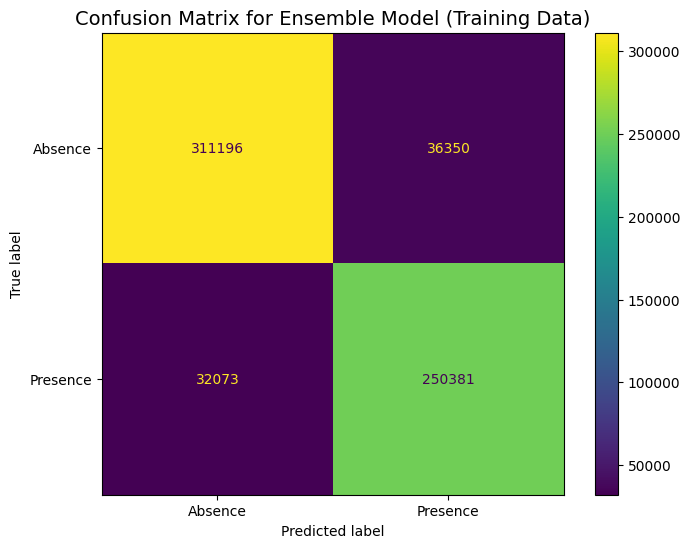

Confusion matrix displayed.


In [56]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Evaluating the ensemble model performance on training data...")

# 1. Make predictions on the training data X_processed
print("Making predictions...")
y_proba = ensemble_model.predict_proba(X_processed)[:, 1]  # Probabilities for the positive class (class 1)
y_pred = ensemble_model.predict(X_processed)              # Predicted class labels
print("Predictions complete.")

# 2. Calculate performance metrics
print("Calculating performance metrics...")
roc_auc = roc_auc_score(y, y_proba)
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
mcc = matthews_corrcoef(y, y_pred)
print("Metrics calculation complete.")

# 3. Print all calculated metrics
print("\n--- Ensemble Model Performance on Training Data ---")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print("---------------------------------------------------")

# 4. Generate and display a confusion matrix
print("Generating confusion matrix...")
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Absence', 'Presence'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='viridis', ax=ax)
ax.set_title('Confusion Matrix for Ensemble Model (Training Data)', fontsize=14)
plt.show()
print("Confusion matrix displayed.")

Extracting and normalizing feature importances from optimized models...
Feature importances extracted, normalized, and stored.

--- Top 5 Optimized LightGBM Feature Importances ---


,Feature,Importance
34,mean__Max HR,0.120897
33,mean__Cholesterol,0.070390
31,mean__Age,0.057379
2,minmax__Cholesterol,0.048439
32,mean__BP,0.047171



--- Top 5 Optimized XGBoost Feature Importances ---


,Feature,Importance
43,mean__Thallium,0.240541
22,ordinal__Thallium,0.228410
30,frqc__Thallium,0.138183
55,count__Number of vessels fluro,0.078867
16,ordinal__Chest pain type,0.050208


Visualizing feature importances from optimized models...


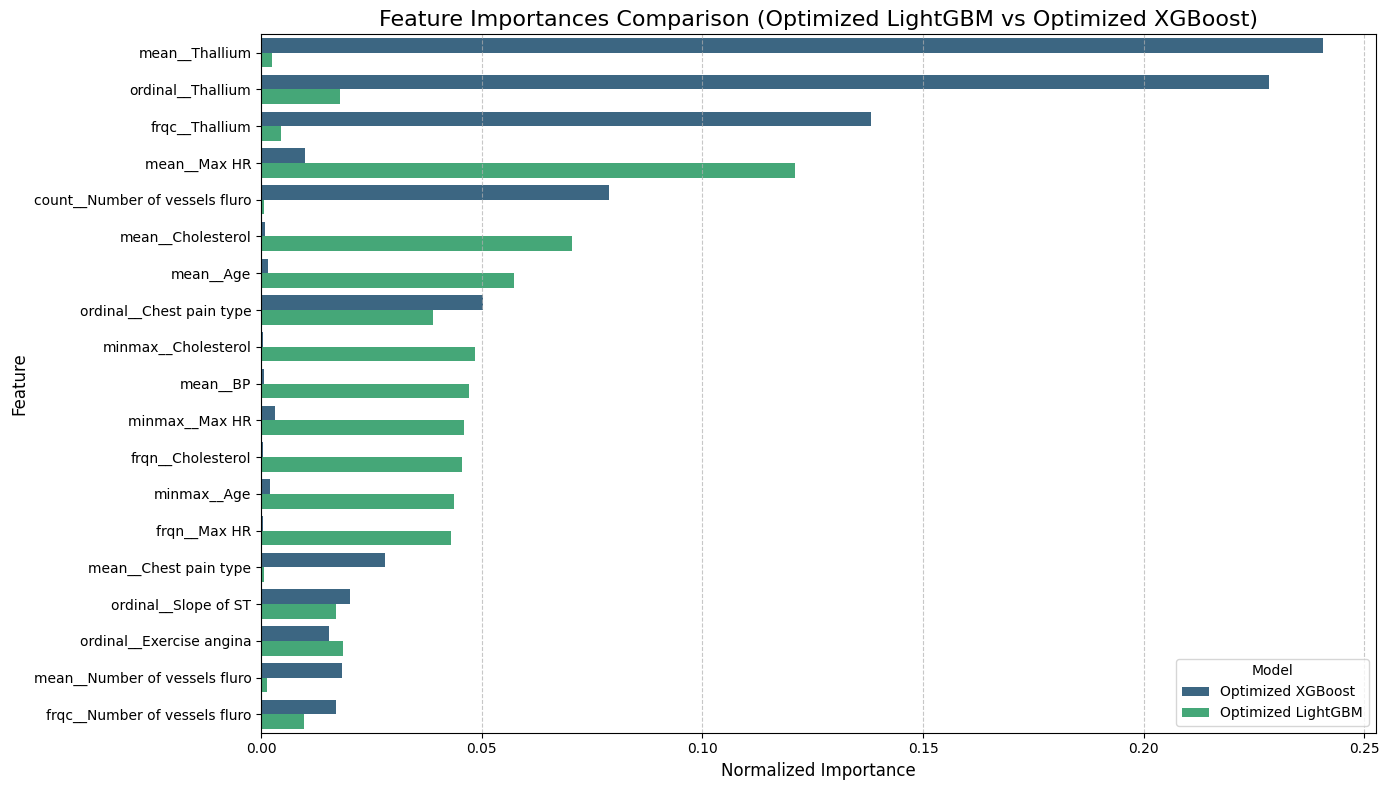

Feature importance visualization complete.


In [57]:
print("Extracting and normalizing feature importances from optimized models...")

# Get feature importances from optimized LightGBM
lgbm_importances = final_lgbm_model.feature_importances_

# Get feature importances from optimized XGBoost
xgb_importances = final_xgb_model.feature_importances_

# Get feature names from the processed training data
feature_names = X_processed.columns

# Create a DataFrame for LightGBM feature importances
df_lgbm_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': lgbm_importances
}).sort_values(by='Importance', ascending=False)

# Create a DataFrame for XGBoost feature importances
df_xgb_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

df_lgbm_importances['Importance'] = df_lgbm_importances['Importance'] / df_lgbm_importances['Importance'].sum()
df_xgb_importances['Importance'] = df_xgb_importances['Importance'] / df_xgb_importances['Importance'].sum()

print("Feature importances extracted, normalized, and stored.")

print("\n--- Top 5 Optimized LightGBM Feature Importances ---")
display(df_lgbm_importances.head())

print("\n--- Top 5 Optimized XGBoost Feature Importances ---")
display(df_xgb_importances.head())

print("Visualizing feature importances from optimized models...")

# Combine the feature importances into a single DataFrame for easier plotting
df_combined_importances = pd.concat([
    df_lgbm_importances.assign(Model='Optimized LightGBM'),
    df_xgb_importances.assign(Model='Optimized XGBoost')
])

# Select top N features for visualization (e.g., top 10)
N = 10
top_lgbm_features = df_lgbm_importances.head(N)['Feature'].tolist()
top_xgb_features = df_xgb_importances.head(N)['Feature'].tolist()
all_top_features = list(set(top_lgbm_features + top_xgb_features))

df_plot = df_combined_importances[df_combined_importances['Feature'].isin(all_top_features)]

# Create a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Importance', y='Feature', hue='Model', data=df_plot.sort_values(by='Importance', ascending=False), palette='viridis')
plt.title('Feature Importances Comparison (Optimized LightGBM vs Optimized XGBoost)', fontsize=16)
plt.xlabel('Normalized Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='Model')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Feature importance visualization complete.")

Generating ROC Curve for the improved ensemble model...


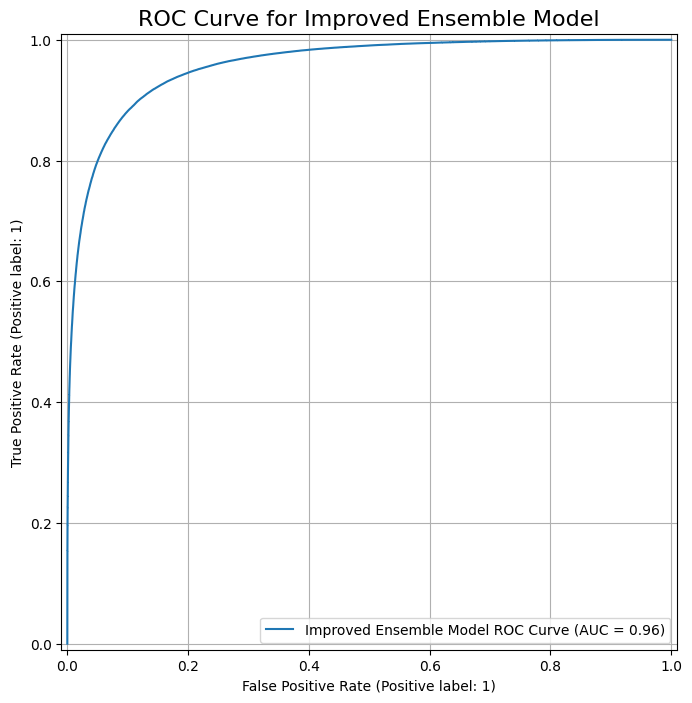

ROC Curve for improved ensemble model generated and displayed.


In [58]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

print("Generating ROC Curve for the improved ensemble model...")

# Create an ROC curve plot
fig, ax = plt.subplots(figsize=(10, 8))
roc_display = RocCurveDisplay.from_predictions(
    y_true=y,
    y_pred=y_proba,
    name='Improved Ensemble Model ROC Curve',
    ax=ax
)

ax.set_title('ROC Curve for Improved Ensemble Model', fontsize=16)

plt.grid(True)
plt.show()
print("ROC Curve for improved ensemble model generated and displayed.")

In [59]:
print("\n" + "✨"*10 + " FINAL RESULTS " + "✨"*10)
print("="*80)

print(f"\n📊 **Ensemble Model Performance on Training Data**")
print(f"   - ROC AUC Score: {roc_auc:.4f}")
print(f"   - Accuracy Score: {accuracy:.4f}")
print(f"   - F1-Score: {f1:.4f}")
print(f"   - Matthews Correlation Coefficient (MCC): {mcc:.4f}")

print("\n" + "="*80)

print("Re-generating predictions on the test set for submission file...")

# Preprocess the test data
X_test_processed = final_preprocessing.transform(df_test[X.columns])

y_test_proba = ensemble_model.predict_proba(X_test_processed)[:, 1]
submission_df = pd.DataFrame({
    'id': df_test['id'],
    'Heart Disease': y_test_proba
})

submission_df.to_csv('submission.csv', index=False)
print("\n✅ Saved: submission.csv")

print("\n✅ Submission file 'submission.csv' has been created.")
print("   First 5 rows of the submission file:")
display(submission_df.head())

print("\n" + "="*80)
print("✨ ENSEMBLE MODELING COMPLETE! ✨")
print("="*80)


✨✨✨✨✨✨✨✨✨✨ FINAL RESULTS ✨✨✨✨✨✨✨✨✨✨

📊 **Ensemble Model Performance on Training Data**
   - ROC AUC Score: 0.9583
   - Accuracy Score: 0.8914
   - F1-Score: 0.8798
   - Matthews Correlation Coefficient (MCC): 0.7808

Re-generating predictions on the test set for submission file...

✅ Saved: submission.csv

✅ Submission file 'submission.csv' has been created.
   First 5 rows of the submission file:


,id,Heart Disease
0,630000,0.841184
1,630001,0.026198
2,630002,0.982594
3,630003,0.026585
4,630004,0.282463



✨ ENSEMBLE MODELING COMPLETE! ✨
